# High dimensional Statistic - M2 TIDE

#### *KORAIBI Kamar & YALAP Sophia*

# Introduction

The purpose of this study is to apply some classification approaches **(SVM, Boosting, NMF etc)** on the Titanic dataset provided and illustrate their results **(performance criterion, graphs, ...)**, tune the parameters and compare these approaches

Task repartition :
- **KAMAR Koraibi** : EDA, Pre-processing, Machine Learning techniques
- **YALAP Sophia** : EDA, Clustering

### Table of Contents
*  [Introduction](#Introduction)

*  [EDA](#EDA)
    
*  [Pre-processing](#Pre-processing)
    * [Train/test split](#Train_Test)
    *  [Feature selection](#Feature_selection)
        * [Univariate selection](#1.Univariate_selection)
        * [Feature importance - Tree Based Classifier](#2.Feature_importance-CART)
        * [Permutation feature importance - sklearn](#3.PermutationFeatureImportance-Sklearn) 
    * [Feature Scaling](#Feature_Scaling)
        
*  [Machine Learning techniques](#Machine_Learning_techniques)
    * [SVM / Kernel SVM](#SVM_KernelSVM)
    * [Ensemble Learning models](#Ensemble_Learning)
         * [Adaboost](#Adaboost)
         * [Xgboost](#Xgboost)
    * [ROC-AUC Comparison](#ROC-AUC)
*  [Clustering](#Clustering)
    * [Raw data](#1.Raw_data)
    * [Dimension reduction - PCA](#2.Dimension_reduction_PCA)
    * [Dimension reduction - NMF](#3.Dimension_reduction_NMF)
    * [Dimension reduction - Comparison](#4.Dimension_reduction_comparison)

# EDA

### Members : KORAIBI Kamar & YALAP Sophia

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression # sc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing data
df = pd.read_csv("titanic.csv")
train = pd.read_csv("train-data.csv")
test = pd.read_csv("test-data.csv")

### SweetViz - quick view
Sweetviz is an open-source Python library that generates beautiful, high-density visualizations to kickstart EDA (Exploratory Data Analysis) with just two lines of code. Output is a fully self-contained HTML application. The system is built around quickly visualizing target values and comparing datasets. I will use this package at first but then I will analyse the data manually.

In [3]:
import sweetviz as sv
my_report = sv.analyze(df)
my_report.show_html()

                                             |                             | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [4]:
print(f'df shape : {df.shape}\ntrain shape : {train.shape}\ntest shape : {test.shape}')

df shape : (156, 13)
train shape : (712, 25)
test shape : (179, 25)


We will be working on the train/test data sets. But first, we will take a glance on the titanic.csv (df) data set to see the original column structure of the data.

In [5]:
# df gives an overview of the original columns of the data set.
df.head()

,PassengerId,Survived,Pclass,Lname,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# column type
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Lname           object
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

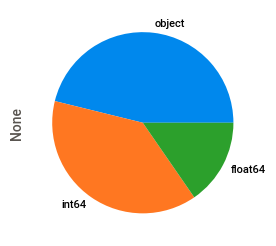

In [7]:
plt.figure(figsize=(8,3))
df.dtypes.value_counts().plot.pie();

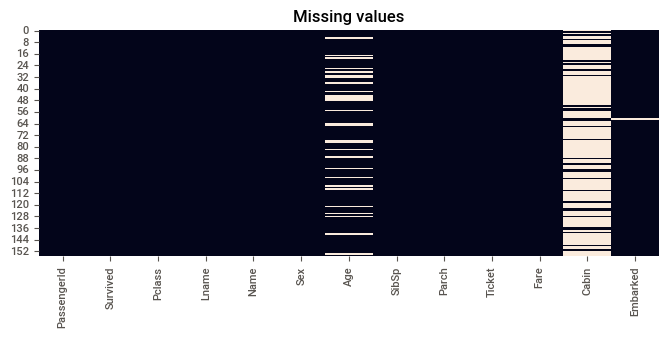

In [8]:
plt.figure(figsize=(8,3))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missing values')
plt.show()

We notice that the Cabin and Age columns have many missing values in this sample, but this is not a concern because we will work with the train and test bases for the modeling part.

In [9]:
# checking duplicates
dfs = [df,train,test]
for d in dfs:
    if d[d.duplicated(keep=False)].shape[0]==0:
        print('No duplicates')

No duplicates


In [10]:
# average age per sex and pclass
df.groupby(['Sex','Pclass']).agg({'Age':'mean'})

Age
Sex    Pclass           
female 1       35.250000
       2       24.625000
       3       21.203704
male   1       39.315789
       2       30.578235
       3       26.255814

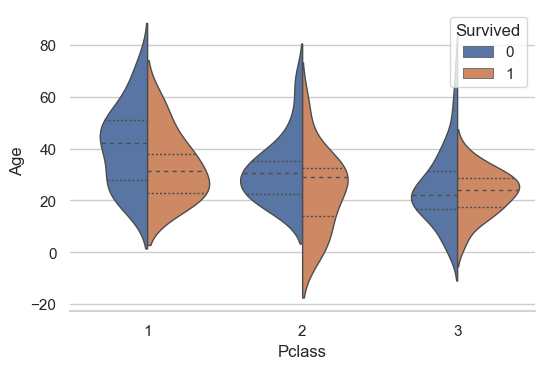

In [11]:
# age vs Pclass / survived
sns.set_theme(style="whitegrid")
sns.violinplot(data=df, x="Pclass", y="Age", hue="Survived",
               split=True, inner="quart", linewidth=1)
sns.despine(left=True)

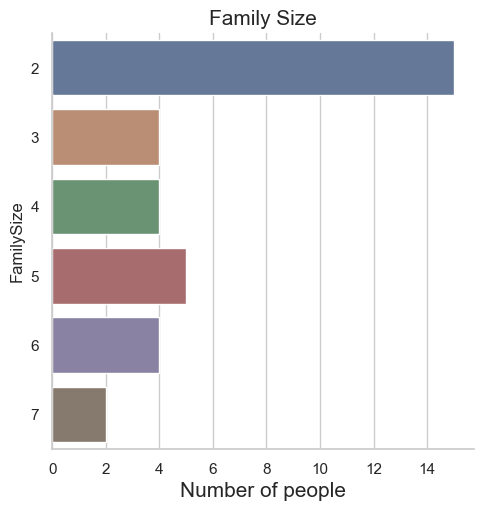

In [13]:
# family size for data vizualisation
df['FamilySize'] = df['SibSp'] + df['Parch']

# countplot 
sns.catplot(y='FamilySize', kind='count',data=df[df.FamilySize>=2], aspect=1,height=5,saturation=0.5)
plt.title("Family Size", size=15)
plt.xlabel("Number of people",size=15)
plt.show()

In [14]:
df.drop('FamilySize',axis=1,inplace=True) # Deletion of the previously created variable to avoid autocorrelation

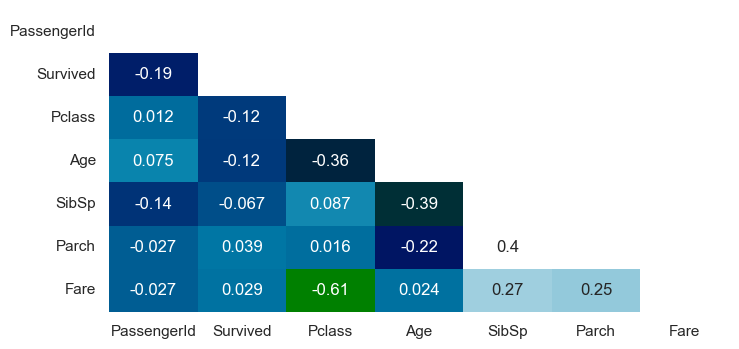

In [15]:
# CORRELATION MATRIX
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(),annot=True,cmap="ocean",cbar=False,mask=np.triu(np.ones_like(df.corr(), dtype = bool)))
plt.show()

In [16]:
corr_matrix = df.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

def top_correlation(df,n):
    correlation = upper_tri.stack().sort_values(ascending=False)
    correlation = pd.DataFrame(correlation).reset_index()
    correlation.columns=["Variable 1","Variable 2","Correlation"]
    correlation = correlation.reindex(correlation.Correlation.abs().sort_values(ascending=False).index).reset_index().drop(["index"],axis=1)
    return correlation.head(n)

top_correlation(df,10)

,Variable 1,Variable 2,Correlation
0,Pclass,Fare,-0.607256
1,SibSp,Parch,0.399040
2,Age,SibSp,-0.393500
3,Pclass,Age,-0.362627
4,SibSp,Fare,0.271997
5,Parch,Fare,0.254822
6,Age,Parch,-0.215169
7,PassengerId,Survived,-0.192991
8,PassengerId,SibSp,-0.136420
9,Survived,Age,-0.120416


Variables are not highly correlated.

**Let's take a look on the feature Survived**

We try to see if the distribution of the data varies with the survival of the individual.

In [17]:
# % survival for each class
df.groupby('Pclass')['Survived'].mean()

Pclass
1    0.400000
2    0.466667
3    0.291667
Name: Survived, dtype: float64

We can see that 1st and 2nd class are more likely to survive than 3rd class

In [18]:
# % survival by class and embarked
df.groupby(['Pclass','Embarked'])['Survived'].mean()

Pclass  Embarked
1       C           0.333333
        S           0.411765
2       C           0.500000
        S           0.461538
3       C           0.375000
        Q           0.538462
        S           0.223881
Name: Survived, dtype: float64

We can see that only 3rd class passangers used Q as port of embarkation. Le 3rd class survival rate on the Q port of embarkation is higher than the 3rd class survival rate for other port of embarkation

This raises the question of whether the feature Embarked is influential in predicting the survival of an individual

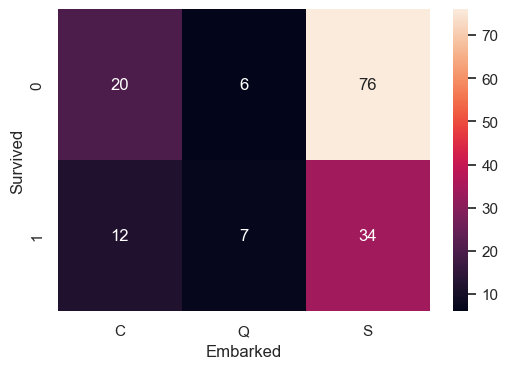

In [19]:
sns.heatmap(pd.crosstab(df['Survived'], df['Embarked']), annot=True, fmt='d');

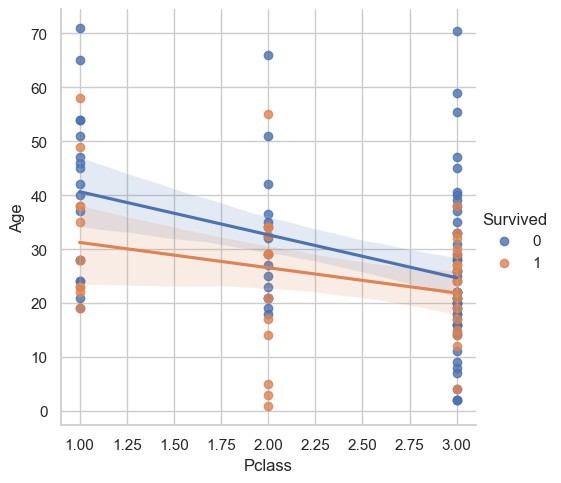

In [20]:
# Age and pclass
sns.lmplot(x = 'Pclass', y = 'Age', hue='Survived', data = df);

Let's plot the distribution for each feature

In [21]:
df['Sex'].replace(['male', 'female'], [0,1], inplace=True)

nsurvived = df[df['Survived'] == 0]
survived = df[df['Survived'] == 1]

<Figure size 600x400 with 0 Axes>

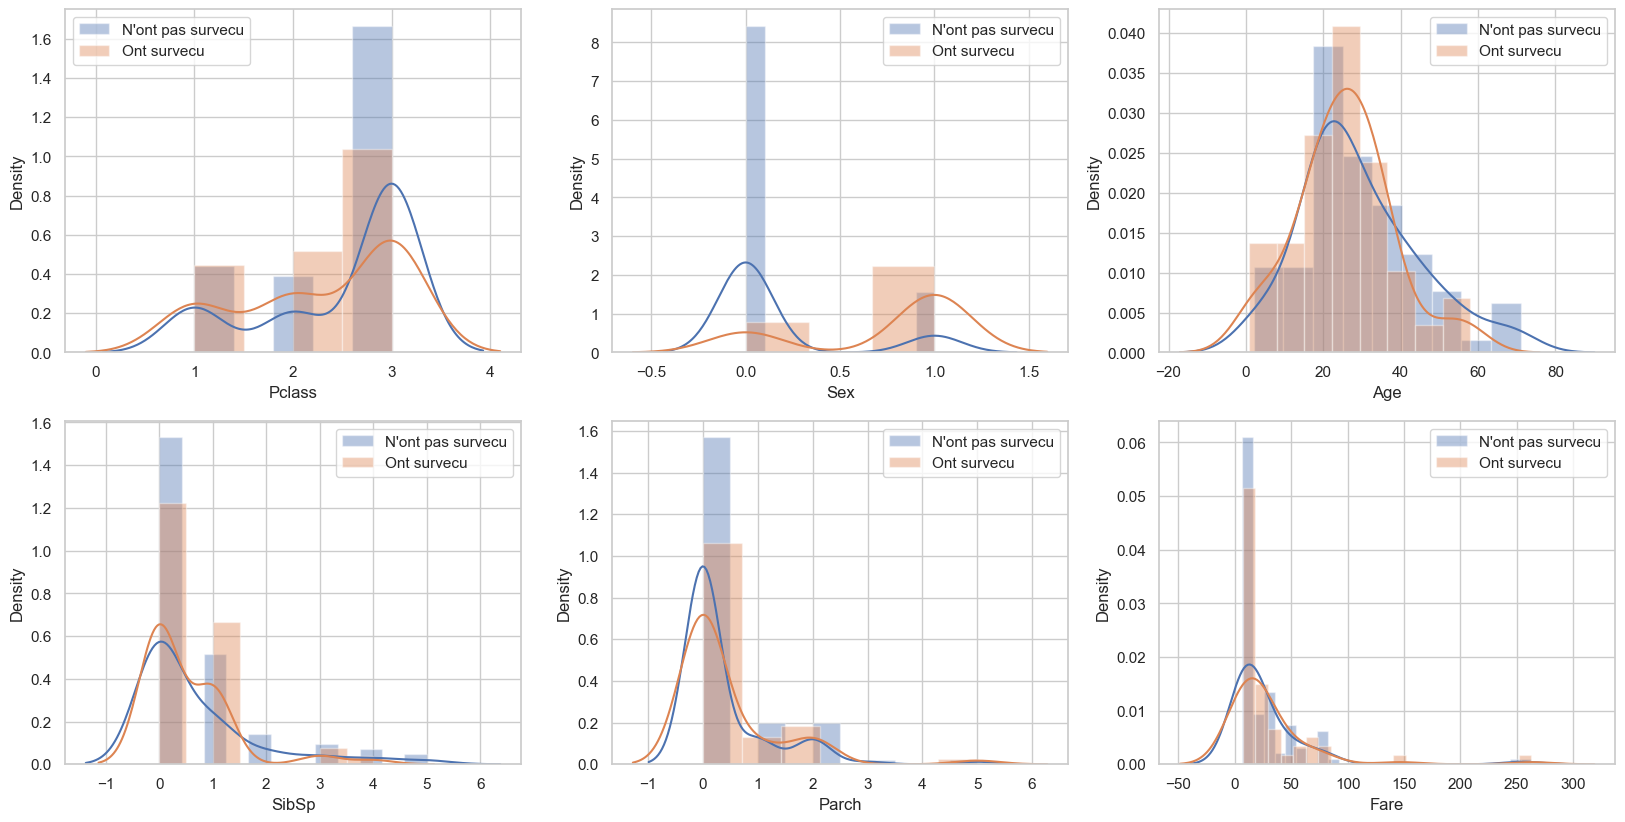

In [22]:
plt.figure()

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sns.distplot(nsurvived['Pclass'], label = "N'ont pas survecu", ax = axes[0,0])
sns.distplot(survived['Pclass'], label = "Ont survecu", ax = axes[0,0]).legend()

sns.distplot(nsurvived['Sex'], label = "N'ont pas survecu", ax = axes[0,1])
sns.distplot(survived['Sex'], label = "Ont survecu", ax = axes[0,1]).legend()

sns.distplot(nsurvived['Age'], label = "N'ont pas survecu", ax = axes[0,2])
sns.distplot(survived['Age'], label = "Ont survecu", ax = axes[0,2]).legend()

sns.distplot(nsurvived['SibSp'], label = "N'ont pas survecu", ax = axes[1,0])
sns.distplot(survived['SibSp'], label = "Ont survecu", ax = axes[1,0]).legend()

sns.distplot(nsurvived['Parch'], label = "N'ont pas survecu", ax = axes[1,1])
sns.distplot(survived['Parch'], label = "Ont survecu", ax = axes[1,1]).legend()

sns.distplot(nsurvived['Fare'], label = "N'ont pas survecu", ax = axes[1,2])
sns.distplot(survived['Fare'], label = "Ont survecu", ax = axes[1,2]).legend()

plt.show();

Wa can see that the distribution curves are similar for an individual who has survived or not. This phenomenon can be seen with all variables except Sex and Age.
We can assume that these variables will be influential in predicting the survival of an individual.

According to the Sex graph, women are more likely to survive than men.

# Preprocessing

### Members : KORAIBI Kamar

## Train / Test 

In [23]:
train.columns 
# deleted Cabin from df because 

Index(['Survived', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2',
       'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

The variables Id, Lname, Name and Ticket are not present in the train and test datasets because they are not considered useful for the modeling although it could have been interesting to analyze the titles (mrs,mr,dr..). The other character variables have been encoded

In [24]:
train.shape

(712, 25)

In [25]:
train.isna().sum().sum()
test.isna().sum().sum()
# no missing values in train nor test.

0

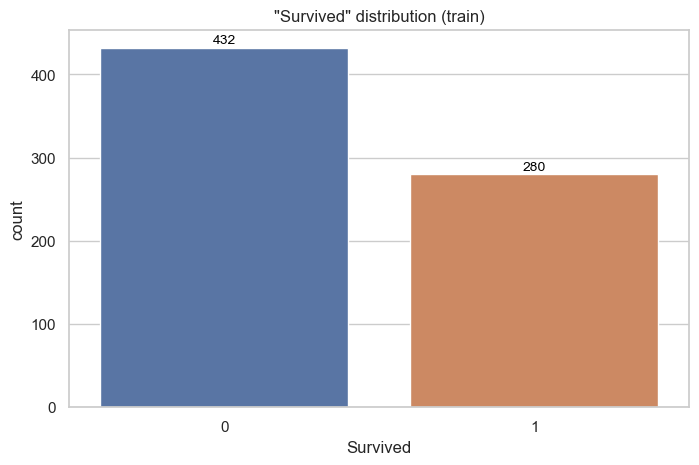

In [26]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
ax = sns.countplot(train['Survived'])
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.title('"Survived" distribution (train)')
plt.show();

The data is not perfectly balanced but it is ok, there is no need to resample.

In [27]:
# Age variable description (train)
pd.DataFrame(train.Age.describe()).T

,count,mean,std,min,25%,50%,75%,max
Age,712.0,29.674341,12.986095,0.42,22.0,29.699118,35.0,80.0


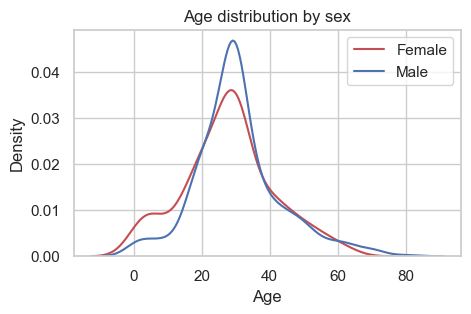

In [28]:
plt.figure(figsize=(5,3))
sns.distplot(train[train['Sex_female']==1]['Age'],hist=False,kde=True,color='r')
sns.distplot(train[train['Sex_male']==1]['Age'],hist=False,kde=True,color='b')
plt.legend(labels=["Female","Male"])
plt.title('Age distribution by sex');

# Train_Test

The given data is already split into two data sets : training (size of 80%) and test (size of 20%). I usually use also a validation set when I have got algorithms to tune because it provides a great insight into whether the model is overfitting or not. I could split the given test set into test and validation but I decided to keep the splits as they were given.

In [29]:
X_train = train.drop('Survived',axis=1)
y_train = train.Survived

X_test = test.drop('Survived',axis=1)
y_test = test.Survived

In [30]:
X_train.shape, X_test.shape

((712, 24), (179, 24))

In [31]:
y_train.value_counts(normalize=True)

0    0.606742
1    0.393258
Name: Survived, dtype: float64

In [32]:
y_test.value_counts(normalize=True)

0    0.653631
1    0.346369
Name: Survived, dtype: float64

Class proportions are almost similar in the train and test sets. Moreover, the train set has a proportion of about 60-40%, I personnaly think that it is not imbalanced enough, so I will not use any resampling technique. 

# Feature_selection
   There are several methods of variable selection among others : 
* Univariate selection : statistical tests can be used to select those features that have the strongest relationship with the output variable.
* Feature importance : the higher the score, the more important or relevant is the feature towards the output variable.
* Permutation feature importance (which will be discussed later on in the modeling part).

### 1.Univariate_selection

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Feature extraction - 8 best features
best_features = SelectKBest(score_func=chi2, k=8)
fit = best_features.fit(X_train,y_train)

In [34]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

In [35]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']

In [36]:
# 8 best features
print(featureScores.nlargest(8,'Score')) # the highest the score, the more important the features are

      Features        Score
1         Fare  3055.343038
5   Sex_female   127.341783
6     Sex_male    72.366035
2     Pclass_1    37.778575
4     Pclass_3    30.581144
21  Embarked_C    13.979501
15     Parch_1    13.091688
8      SibSp_1    11.818931


Chi-square tests for variable selection are not recommended because repeating tests per variable creates a problem of multiple tests, the more tests we have, the greater the probability of error. We can do the Fisher test for a linear regression but the problem persists.

### 2.Feature_importance-CART

In [37]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_)

[0.2436282  0.23797023 0.03563814 0.01840319 0.05207464 0.12255299
 0.15068073 0.01709495 0.0135847  0.00528195 0.00892492 0.0041949
 0.0009251  0.00212306 0.01758642 0.01436521 0.00938151 0.0011233
 0.00268738 0.0026483  0.00050872 0.01280613 0.0085401  0.01727522]


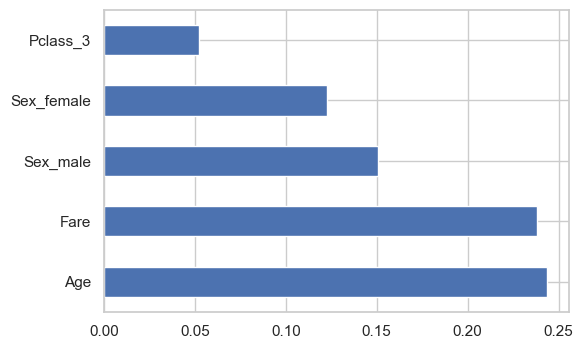

In [38]:
feat_imp = pd.Series(model.feature_importances_,index=X_train.columns)
feat_imp.nlargest().plot(kind='barh')
plt.show()

However, as seen in class, it turns out that the variable selection methods based on decision trees are not always reliable and can be strongly biased. I personally prefer to opt for the permutation importance method because it selects the important variables according to each algorithm. There exist many other techniques but they have some limits when there are correlated variables (called "associations") and the random permutation breaks this association link. Pycaret package uses the appropriate method by case and therefore the choice of Pycaret is based on the algorithm itself. I will not use Pycaret in this analysis though.

### PermutationFeatureImportance-Sklearn
**Warning :** Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

In case of strongly correlated features, if one of them is permuted, the model will still have access to the feature through its correlated feature which will lead to a low feature importance value for all of them. Therefore, clustering can be used in order to keep only one feature from each cluster.

This method will be seen later in the modeling part.

# Feature_Scaling
Algorithms that computes the distance between the data points (Logistic Regression, KNN, SVM, K-means etc) or are used for matrix factorization or dimensionality reduction (PCA) require feature scaling.

Types of scaling :

**1. MaxAbsScaler() :**
- valeurs dispersées/en désordre + beaucoup d'outliers (les autres techniques effacent l'impact des outliers).

**2. MinMaxScaler()** - Normalization :
$$X_{norm} = \frac{x_i - min(x)}{max(x) - min(x)}$$
- Utilise min-max.
- Calibre les données sur une plage de valeurs.

**3. RobustScaler() :**
$$\frac{x_i - Q_1(x)}{Q_3(x) - Q_1(x)}$$
- Utilise l'intervalle interquantile.
- Plus fiable vis-à-vis des outliers.
($Q_1$ : 25%, $Q_2$ : 75%)

**4. StandardScaler()** - Standardization :
$$\frac{x_i - mean(x)}{sd(x)}$$
- Part du principe que les données sont normalement distribuées.

In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test) # we apply the same training scale on the test data set.

# Machine_Learning_techniques

### Members : KORAIBI Kamar

## SVM_KernelSVM
Support Vector Machines first appeared in the 60s and then were developed in the 90s and became popular more recently in machine learning, being somewhat different from other algorithms and applied in several areas.
The purpose of Support Vector Machines is to separate the data into classes thanks to a separator so that the distance (margin) between the groups of data and the border which separates them is maximum.
The Support Vector Machines is a popular algorithm used for regression as well as classification. Albeit this algorithm takes a long time to work on a large database, SVM remains a fairly robust and efficient method with little risk of overfitting.

In [40]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=16)
svm_clf.fit(X_train,y_train)
y_prd = svm_clf.predict(X_test)

print("SVM classifier Accuracy on Train Dataset (before tuning): {}".format(svm_clf.score(X_train, y_train).round(3)))
print("SVM classifier Accuracy on Test  Dataset (before tuning): {}".format(accuracy_score(y_test,y_prd).round(3)))

SVM classifier Accuracy on Train Dataset (before tuning): 0.652
SVM classifier Accuracy on Test  Dataset (before tuning): 0.726


In [41]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=16)
svm_clf.fit(X_train_sc,y_train)
y_prd = svm_clf.predict(X_test_sc)

print("SVM classifier Accuracy on Train Dataset (before tuning - scaled): {}".format(svm_clf.score(X_train_sc, y_train).round(3)))
print("SVM classifier Accuracy on Test  Dataset (before tuning - scaled): {}".format(accuracy_score(y_test,y_prd).round(3)))

SVM classifier Accuracy on Train Dataset (before tuning - scaled): 0.833
SVM classifier Accuracy on Test  Dataset (before tuning - scaled): 0.804


We notice that the feature scaling improved the performance.

### Hyperparameter tuning algorithms : GridSearch, RandomSearch, Bayesian Optimization
Hyperparameters are parameters that the model cannot learn on its own, we need to tune them in order to improve the performance of our model. 
- Grid Search : every possible combination, but it is inefficient in computing time and power when the number of hyperparameters increase.
- Random Search : we define a sampling distribution for each hyperparameter. We can also set the number of iterations we want.
- Bayesian Optimization : SMBO (Sequential Model-Based Optimization) algorithm, it uses the previous results to decide the next ones.

##### Tuning SVM with GridSearchCV

In [42]:
kernelsvm = SVC()

parameters = [{'C': [0.4,0.5,0.6], 'kernel': ['linear']},
              {'C': [0.4,0.5,0.6], 'kernel': ['rbf'], 'gamma': [0.0005,0.0001,0.001]}]
# the closer we get to C=1, the less strong is the regularization
grid_search = GridSearchCV(estimator = kernelsvm,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 15,
                           n_jobs = -1) # all the machine processors will be used (optional)
grid_search.fit(X_train, y_train)
print(f'Best parameters : {grid_search.best_params_}')

Best parameters : {'C': 0.5, 'kernel': 'linear'}


In [43]:
grid_search.best_estimator_

SVC(C=0.5, kernel='linear')

In [44]:
kern_svm = SVC(C=0.5, kernel='linear')
kern_svm.fit(X_train,y_train) 
y_pred = kern_svm.predict(X_test)

print("SVM classifier Accuracy on Train Dataset (after tuning): {}".format(kern_svm.score(X_train, y_train).round(3)))
print("SVM classifier Accuracy on Test  Dataset (after tuning): {}".format(accuracy_score(y_test,y_pred).round(3)))

SVM classifier Accuracy on Train Dataset (after tuning): 0.802
SVM classifier Accuracy on Test  Dataset (after tuning): 0.804


We notice that the accuracy improved in both training and test sets and the model is not overfitting.

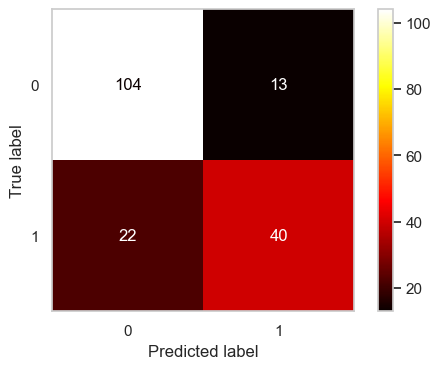

In [45]:
plot_confusion_matrix(kern_svm, X_test, y_test,cmap='hot')
plt.grid(False);

# Ensemble_Learning
Ensemble learning can be defined as the process of combining a multitude of algorithms that are working together in order to improve the predictability of the model. Bagging, boosting and stacking are among the most popular ensemble methods.

## Boosting Techniques
Boosting is an ensemble learning method based on the idea of "wisdom of the crowd", related to the law of large numbers, where the word "crowd" here refers to a group of weak machine learning models. The boosting method combines several binary classifiers to optimize their performance, the principle is based on combining several weak classifiers in order to produce a final and more powerful classifier by the majority vote principle. This is a sequential method, at each new step a new classifier, more suitable than the previous one is built. Classification and Regression Trees are among the most widely used classifiers for boosting. In bagging, the models are trained in parallel and are all relatively strong, each in an over-fitting situation, so bringing together the predictions helps reduce the variance of the set. Conversely, with boosting, the models are trained sequentially and are all weak, each in an under-fitting situation but by building them on top of each other, the overall bias is reduced. Albeit bagging and boosting are two different methods, they achieve the same result - a strong, wide and diverse final set of models.

### Adaboost
Adaptive Boosting, also known as Adaboost, is one of the most used algorithms in boosting.
This algorithm was introduced by Freund and Shapire in 1997 and is employed here to classify
whether the passengers survived or not, given a set of predictive variables.

In [46]:
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(random_state=16)
ada_model.fit(X_train, y_train)

y_ada = ada_model.predict(X_test)

print("Adaboost classifier Accuracy on Train Dataset : {}".format(ada_model.score(X_train, y_train).round(3)))
print("Adaboost classifier Accuracy on Test  Dataset : {}".format(accuracy_score(y_test,y_ada).round(3)))

Adaboost classifier Accuracy on Train Dataset : 0.822
Adaboost classifier Accuracy on Test  Dataset : 0.827


In [47]:
# Permutation Feature Importance
r = permutation_importance(ada_model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{train.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Sex_female 0.182 +/- 0.011
Survived 0.038 +/- 0.007
Pclass_2 0.018 +/- 0.006
Age      0.015 +/- 0.007
SibSp_2  0.015 +/- 0.002
SibSp_3  0.011 +/- 0.003
SibSp_5  0.007 +/- 0.002
Parch_3  0.004 +/- 0.001


Permutation feature importance can be calculated either on the training or validation set. In this analysis I did not use a validation set even though it seems to be very intuitive. So I fitted it on the train set. Features that seem to be important in the training set but not on the test or validation set might lead to overfitting. In this example I chose 30 iterations and the decrease in performance is calculated in each iteration. For the 'Sex_female' column for instance, the 0.182 represents the mean by which the performance of the model decreased on the 30 iterations and 0.011 is the standard deviation.

### Xgboost
XGBoost is one of the most popular variants of the Gradient Boosting, which has been improved recently (2016) in a very powerful version called eXtreme Gradient Boosting (XGBoost) which thus serves to improve the performance and speed of the model. It is an optimized open source implementation of the gradient boosting tree algorithm.

In [48]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)
y_xgb = xgb_model.predict(X_test)

print("Xgboost classifier Accuracy on Train Dataset : {}".format(xgb_model.score(X_train, y_train).round(3)))
print("Xgboost classifier Accuracy on Test  Dataset : {}".format(accuracy_score(y_test,y_xgb).round(3)))

[04:08:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgboost classifier Accuracy on Train Dataset : 0.969
Xgboost classifier Accuracy on Test  Dataset : 0.849


Xgboost overfitted comparing to other algorithms but gave the best results.

In [49]:
# Same procedure as before
r = permutation_importance(xgb_model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{train.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Pclass_3 0.225 +/- 0.010
Age      0.167 +/- 0.008
Survived 0.153 +/- 0.013
Pclass_2 0.089 +/- 0.010
Fare     0.032 +/- 0.004
Parch_6  0.018 +/- 0.004
SibSp_8  0.017 +/- 0.004
Embarked_Q 0.011 +/- 0.003
Embarked_C 0.004 +/- 0.001
Sex_male 0.004 +/- 0.002
Parch_1  0.002 +/- 0.001


In [50]:
# Grid Search CV for XGBOOST
params = {
        'min_child_weight': [3,4,5,6],
        'gamma': [0.6,0.8,1,1.2],
        'subsample': [0.6,0.7,0.8,0.9],
        'colsample_bytree': [0.6,0.7,0.8,1],
        'max_depth': [8,9,10,11,12]
        }
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', n_jobs=-1, cv=15, verbose=1)

Nota : the values that I put in the dictionary were chosen after two consecutive tries which brought me closer to these values.

In [53]:
print(f'Best Estimator : {grid_search.best_estimator_}\nBest Parameters : {grid_search.best_params_}')
print(f'Best Score : {grid_search.best_score_.round(3)}')

Best Estimator : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)
Best Parameters : {'colsample_bytree': 0.7, 'gamma': 1, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7}
Best Score : 0.83


In [54]:
# Tuned model :
xg = xgb.XGBClassifier(colsample_bytree=0.7, gamma=1, max_depth=10, 
                           min_child_weight=4, subsample=0.7)

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
print("XGBOOST classifier Accuracy on Train Dataset : {}".format(xg.score(X_train, y_train).round(3)))
print("XGBOOST classifier Accuracy on Test  Dataset : {}".format(accuracy_score(y_test,y_pred).round(3)))
print(classification_report(y_test,y_pred))

# The test accuracy improved.

[04:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBOOST classifier Accuracy on Train Dataset : 0.893
XGBOOST classifier Accuracy on Test  Dataset : 0.855
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       117
           1       0.82      0.74      0.78        62

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



- macro average = (precision of class 0 + precision of class 1)/2
- weighted average = precision of all classes merged together. $$\frac{TP_0 + TP_1}{Total_0 + Total_1}$$

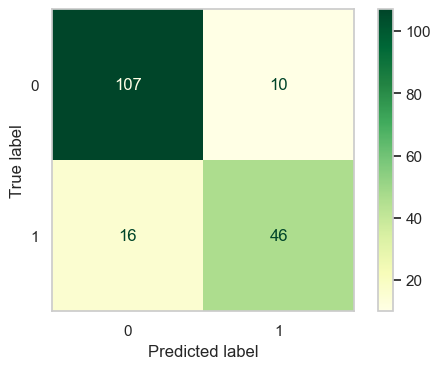

In [56]:
plot_confusion_matrix(xg, X_test, y_test,cmap='YlGn')
plt.grid(False);#OrRd

The test accuracy slightly improved and the model did not overfit.

### ROC-AUC

The Receiver Operating Characteristic (ROC) curve is a statistical tool for evaluating and comparing models, it is a probabilistic measure of the performance of a binary classifier. It is, in fact, a graphical representation of the True Positive Rate - TPR (Sensitivity) on the y-axis and the False Positive Rate - FPR (1-Specificity) on the x-axis with a threshold which varies from 0 to 1. In many applications, the ROC curve provides more interesting information on the quality of learning than the simple error rate. The larger the Area Under the Curve (AUC), the better the model. However, the selection of the threshold depends on the area of expertise, the performance of the model as well as the data.
The area under the curve can be calculated using a sorting algorithm, by calculating integrals from (0,0) to (1,1) :
$$AUC = \int_{0}^{1} {\frac{TP}{TP+FN}} \,d{\frac{FP}{FP+TN}}$$

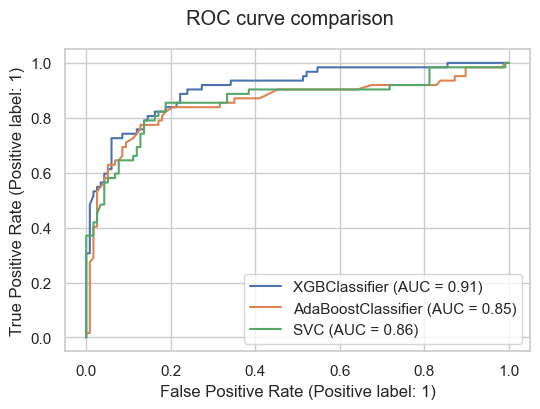

In [57]:
xg_disp = plot_roc_curve(xg, X_test, y_test)
ada_disp = plot_roc_curve(ada_model, X_test, y_test, ax=xg_disp.ax_)
svm_disp = plot_roc_curve(kern_svm, X_test, y_test, ax=xg_disp.ax_)

ada_disp.figure_.suptitle("ROC curve comparison")
plt.grid(True);

In general, the AUC takes values between 0.5 and 1. An AUC that is equal to 0 means that 100% of the predictions are wrong, whereas and AUC equal to 1 means that all predictions are correct and the ROC curve covers the upper left-hand corner. A value of 0.5 implies that predictions are not better than random.

# Clustering

### Members : YALAP Sophia

In this section, we will use the k-means clustering algorithm to define clusters in our dataset. We will also perform a dimension reduction via the PCA and NMF.

**Summary :**
- 1. Use of raw data without dimension reduction
- 2. Dimension reduction with PCA
- 3. Dimension reduction with NMF
- 4. Dimension reduction comparison

In [59]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

In [60]:
train = pd.read_csv("train-data.csv")
test = pd.read_csv("test-data.csv")
print(train.shape, test.shape)

(712, 25) (179, 25)


With a clustering problem, we don't have to have a target. The aim is to find groups of individuals in our dataset. Moreover, we don't need to test our models on a test set. That's why we will work on a merged dataset (training set, test set)

In [61]:
X = pd.concat([train, test])
X.shape

(891, 25)

In [62]:
X.head(2)

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,28.5,7.2292,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
1,1,27.0,10.5000,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1


All variables are binary except Age and Fare

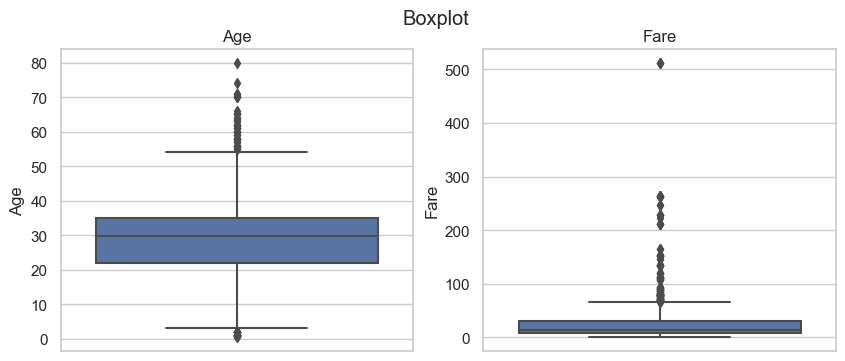

In [64]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(10,4))
fig.suptitle('Boxplot')

sns.boxplot(ax=axes[0], data = X, y = X['Age'])
axes[0].set_title('Age')

sns.boxplot(ax=axes[1], data = X, y = X['Fare'])
axes[1].set_title('Fare')

plt.show();

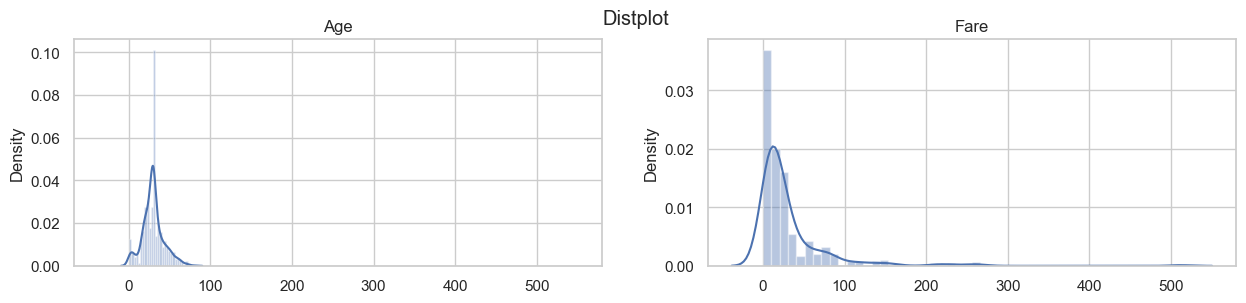

In [65]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(15,3))
fig.suptitle('Distplot')

sns.distplot(ax=axes[0], x = X['Age'])
axes[0].set_title('Age')

sns.distplot(ax=axes[1], x = X['Fare'])
axes[1].set_title('Fare')

plt.show()

We will remove outliers of the variable Fare. Keeping these values could distort the results.

In [66]:
X = X[X['Fare'] < 300]

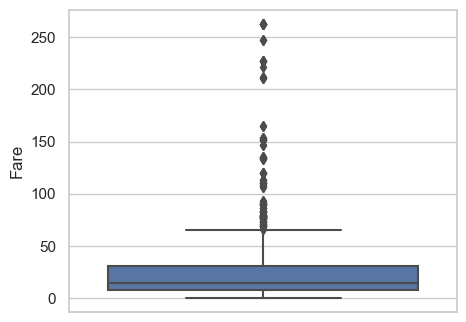

In [79]:
plt.figure(figsize=(5,4))
sns.boxplot(data = X, y = X['Fare']);

### 1.Raw_data

Use of raw data without dimension reduction

Let's try to use Kmean clustering on a normalize dataset, without any reduction dimension

In [68]:
# Standardize data
scaler = StandardScaler() 
scaled_X = scaler.fit_transform(X) 
  
# Normalizing the Data 
normalized_X = normalize(scaled_X) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_X = pd.DataFrame(normalized_X) 

The first thing to do is to define the number of clusters.
The number of clusters can be found with the elbow method.

- **Elbow method**

The elbow method consists in defining the right compromise between a low inertia and a reasonable number of clusters. How does it work ?
We have a graph with the number of clusters on the abscissa and the inertia on the ordinate. When we plot the values, we can locate where the 'bend' is formed and this value will correspond to our optimal number of clusters.

- **Inertia**

How can we calculate the inertia ? Inertia can be recognized as a measure of how internally coherent clusters are.

The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion.

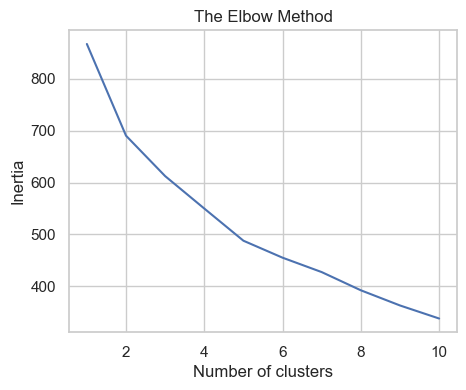

In [80]:
plt.figure(figsize=(5,4))
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(normalized_X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The curve suggests to choose between 4 and 7 clusters but it is difficult to see on the graph the exact time where we have to stop increasing the number of clusters

To mesure the performance of our clustering model, we can use the **silhouette score**. 

The idea is to calculate for each value the distance between our sample and the closest sample which belongs to the other class. This is called the silhouette coefficient. The silhouette score returns the average silhouette coefficient over all samples with the following properties: 
- 1 is the highest value
- -1 is the lowest value
- 0 indicates overlapping clusters
- Negative values generally indicate that a sample has been assigned to the wrong group, as a different group is more similar

In [81]:
# KMeans algorithm with 7 clusters
kmeans = KMeans(n_clusters=7)
kmeans.fit(normalized_X)
inertia = kmeans.inertia_
print("Silhouette score : ", silhouette_score(normalized_X, KMeans(n_clusters = 7).fit_predict(normalized_X)))
print("Inertia : ", inertia)

Silhouette score :  0.31617766761756677
Inertia :  426.14717566800977


As we said earlier, inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

- Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.

### 2.Dimension_reduction_PCA

PCA will allow us not only to improve the problems related to inertia but also to visualize the data and the clusters

In [83]:
# Reducing the dimensions of the data with PCA
pca = PCA(n_components = 2) 
PCA_X = pca.fit_transform(normalized_X) 
PCA_X = pd.DataFrame(PCA_X) 
PCA_X.columns = ['P1', 'P2'] 
  
PCA_X.head(2)

,P1,P2
0,-0.258408,-0.316728
1,0.402450,0.242527


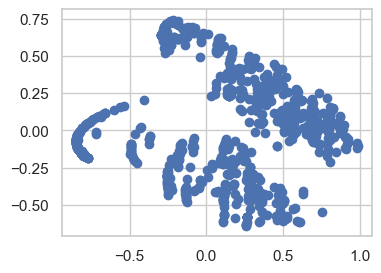

In [93]:
plt.figure(figsize=(4,3))
plt.scatter(PCA_X['P1'], PCA_X['P2'],cmap =plt.cm.winter);

<Figure size 400x300 with 0 Axes>

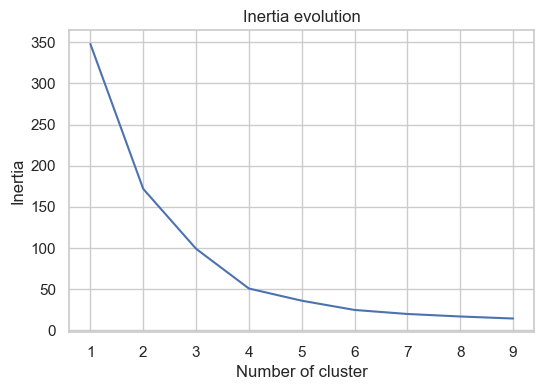

In [94]:
plt.figure(figsize=(4,3))
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(PCA_X)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.ylabel("Inertia")
plt.title('Inertia evolution')
plt.show();

Thanks to the graph, we can see that a good choice for the number of clusters would be between 4 and 6. To decide which one we will use, let's display the silhouette score for a number of cluster between 4 and 7.

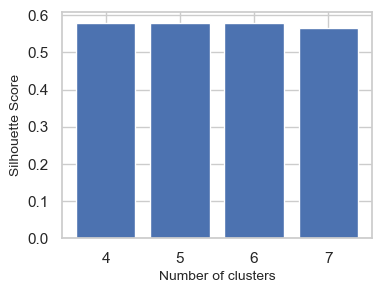

In [95]:
plt.figure(figsize=(4,3))
silhouette_scores = [] 

for n_cluster in range(4, 8):
    silhouette_scores.append( 
        silhouette_score(PCA_X, KMeans(n_clusters = n_cluster).fit_predict(PCA_X))) 
    
# Plotting a bar graph to compare the results 
k = [4, 5, 6, 7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

The silhouette score is the same for all values so we decide to keep the value 4 as the number of clusters.

In [96]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(PCA_X)
print("silhouette score : ", silhouette_score(PCA_X, KMeans(n_clusters = 4).fit_predict(PCA_X)))
print("Inertia : ", kmeans.inertia_)

silhouette score :  0.5792772601042314
Inertia :  50.949124903977456


We can observe an increase of the silhouette score and a decrease of the inertia.

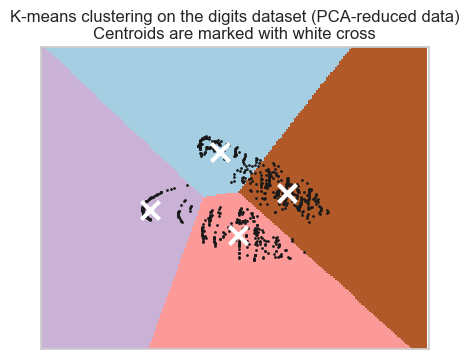

In [118]:
plt.figure(figsize=(5,4))
reduced_data = PCA(n_components=2).fit_transform(normalized_X)
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Source : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

Now that the pca gives us good values, let's try with the nmf method

### 3.Dimension_reduction_NMF

Before using the NMF we have to make sure that our values are not negative. The normalized and standardized data are negative. We will start with the raw data.

In [98]:
X.head(2)

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,28.5,7.2292,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
1,1,27.0,10.5000,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1


Only the variables Ages and Fare are not binary (positive or null). Given their description, they should not be negative but it is always safer to check.

In [99]:
print("  Number of rows with negative values for the variable age : ", (X[X['Age'] < 0].shape))
print("  Number of rows with negative values for the variable fare : ", (X[X['Fare'] < 0].shape))

  Number of rows with negative values for the variable age :  (0, 25)
  Number of rows with negative values for the variable fare :  (0, 25)


There is no one, we can use NMF

In [100]:
# We want to have 2 components
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_
W = pd.DataFrame(W)

In [101]:
print(X.shape, W.shape, H.shape)

(888, 25) (888, 2) (2, 25)


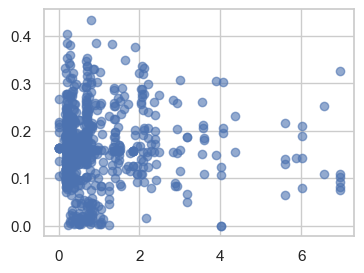

In [119]:
plt.figure(figsize=(4,3))
plt.scatter(W[0], W[1], alpha = 0.6);

In [122]:
# Define the algorithm in a function
def algo_kmeans(X, iteration):
    s = []
    inert = []
    for i in range(2,iteration+1):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
        kmeans.fit(X)
        inertia = kmeans.inertia_
        inert.append(inertia)
        sscore = silhouette_score(X, KMeans(n_clusters = i).fit_predict(X))
        s.append(sscore)
        print("Number of clusters : ", i, " - Inertia : ", inertia, " - Silhouette score : ", sscore)
        
    k = [i for i in range(2, iteration+1)]
    # Plotting two graphs to compare the results
    plt.figure(figsize=(10,4))

    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    ax1.title.set_text('Inertia')
    ax1.plot(k, inert)

    ax2.title.set_text('Silhouette score')
    ax2.bar(k,s);

Number of clusters :  2  - Inertia :  362.8273170631708  - Silhouette score :  0.8176088583670559
Number of clusters :  3  - Inertia :  141.73036297186113  - Silhouette score :  0.7481399706390834
Number of clusters :  4  - Inertia :  77.80329687465165  - Silhouette score :  0.7373857102149323
Number of clusters :  5  - Inertia :  41.372847712165616  - Silhouette score :  0.6559526490095677
Number of clusters :  6  - Inertia :  29.0429903432799  - Silhouette score :  0.6530179886367977
Number of clusters :  7  - Inertia :  22.67474720884018  - Silhouette score :  0.6537182922069562
Number of clusters :  8  - Inertia :  18.082573088860492  - Silhouette score :  0.6543711201962522
Number of clusters :  9  - Inertia :  14.403005987286743  - Silhouette score :  0.5512791231015156
Number of clusters :  10  - Inertia :  12.182963159178762  - Silhouette score :  0.5440222465059467


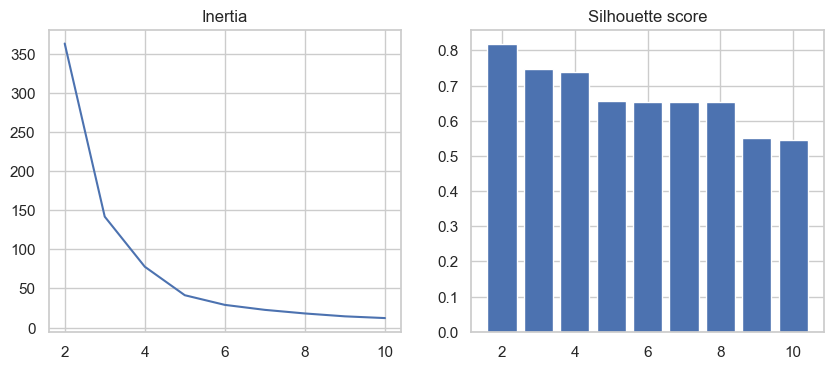

In [123]:
# Use the function on W
algo_kmeans(W, 10)

The NMF algorithm has many parameters :

- **n_components :** Number of components, if n_components is not set all features are kept.


- **init :** Method used to initialize the procedure.


- **Numerical solver to use:** ‘cd’ is a Coordinate Descent solver. ‘mu’ is a Multiplicative Update solver.


- **beta_divergence :** Beta divergence to be minimized, measuring the distance between X and the dot product WH. Note that values different from ‘frobenius’ (or 2) and ‘kullback-leibler’ (or 1) lead to significantly slower fits. Note that for beta_loss <= 0 (or ‘itakura-saito’), the input matrix X cannot contain zeros. Used only in ‘mu’ solver.

Source : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [124]:
# Fitting the NMF model (generalized Kullback-Leibler divergence)
model = NMF(n_components=2, init='random', random_state=0, beta_loss="kullback-leibler", solver = "mu")
W_bis = model.fit_transform(X)
H_bis = model.components_
W_bis = pd.DataFrame(W_bis)

Number of clusters :  2  - Inertia :  1662.022989889015  - Silhouette score :  0.7736108781205324
Number of clusters :  3  - Inertia :  862.7964545792993  - Silhouette score :  0.6420921344211857
Number of clusters :  4  - Inertia :  619.3281832708958  - Silhouette score :  0.6159147582822774
Number of clusters :  5  - Inertia :  449.40874210163827  - Silhouette score :  0.47312379909006097
Number of clusters :  6  - Inertia :  344.41216382460414  - Silhouette score :  0.47699058783111115
Number of clusters :  7  - Inertia :  283.72001276954984  - Silhouette score :  0.5035573882840344
Number of clusters :  8  - Inertia :  241.5595905814967  - Silhouette score :  0.49766738206003663
Number of clusters :  9  - Inertia :  215.44116263984242  - Silhouette score :  0.5014169310474762
Number of clusters :  10  - Inertia :  194.93559505119185  - Silhouette score :  0.43155925034947473


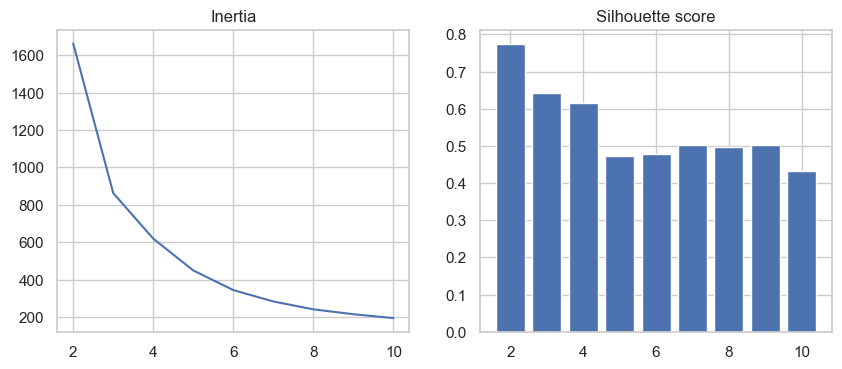

In [125]:
algo_kmeans(W_bis, 10)

The silhouette score and inertia results for a beta_loss frobenius were better 

Centroid positions :  [[0.59370823 0.15989257]
 [4.4384303  0.15795351]]


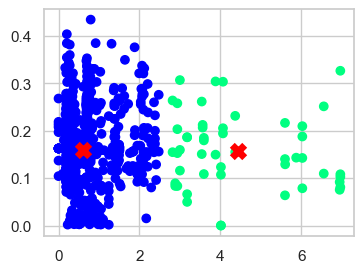

In [126]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(W)

centroids = kmeans.cluster_centers_
print("Centroid positions : ", centroids)

# Visualizing the clustering 
plt.figure(figsize=(4,3))
plt.scatter(W[0], W[1],  
           c = KMeans(n_clusters = 2).fit_predict(W), cmap =plt.cm.winter)
plt.scatter(centroids[:,0],centroids[:,1],marker = "x", s=80,linewidths = 5, zorder = 10, c='red')
plt.show() 

### 4.Dimension_reduction_comparison

Here the goal is to compare the PCA and NMF approaches for clustering. To do so, we will rely on the silhouette score

In [127]:
n_components_options = [2, 3, 4, 5, 6]
S_PCA = []
S_NMF = []

for i in n_components_options:
    print("***** Round *****", i)
    
    #PCA dimension reduction
    pca = PCA(n_components = i)
    PCA_X = pca.fit_transform(normalized_X) 
    PCA_X = pd.DataFrame(PCA_X)

    #NMF dimension reduction
    model = NMF(n_components=i, init='random', random_state=0)
    NMF_X = model.fit_transform(X)
    H = model.components_
    NMF_X = pd.DataFrame(NMF_X)
    
    s_pca = []
    s_nmf = []
    highest_sscore_pca = -1
    highest_sscore_nmf = -1
    
    for j in range(2,11):
        kmeans = KMeans(n_clusters = j, init = 'k-means++', max_iter = 300, n_init = 10)
        kmeans.fit(PCA_X)
        inertia = kmeans.inertia_
        sscore_pca = silhouette_score(PCA_X, KMeans(n_clusters = j).fit_predict(PCA_X)).round(3)
        s_pca.append(sscore_pca)
        if sscore_pca > highest_sscore_pca:
            highest_sscore_pca = sscore_pca
            
        kmeans = KMeans(n_clusters = j, init = 'k-means++', max_iter = 300, n_init = 10)
        kmeans.fit(NMF_X)
        inertia = kmeans.inertia_
        sscore_nmf = silhouette_score(NMF_X, KMeans(n_clusters = j).fit_predict(NMF_X)).round(3)
        s_nmf.append(sscore_nmf)
        if sscore_nmf > highest_sscore_nmf:
            highest_sscore_nmf = sscore_nmf
            
    print("Highest silhouette score with PCA : ", highest_sscore_pca)
    print("Highest silhouette score with NMF : ", highest_sscore_nmf)
    S_PCA.append(highest_sscore_pca)
    S_NMF.append(highest_sscore_nmf)

***** Round ***** 2
Highest silhouette score with PCA :  0.581
Highest silhouette score with NMF :  0.818
***** Round ***** 3
Highest silhouette score with PCA :  0.563
Highest silhouette score with NMF :  0.702
***** Round ***** 4
Highest silhouette score with PCA :  0.498
Highest silhouette score with NMF :  0.605
***** Round ***** 5
Highest silhouette score with PCA :  0.508
Highest silhouette score with NMF :  0.759
***** Round ***** 6
Highest silhouette score with PCA :  0.459
Highest silhouette score with NMF :  0.802


In [128]:
ar = np.array([[2, S_PCA[0], "PCA"], [2, S_NMF[0], "NMF"], 
               [3, S_PCA[1], "PCA"], [3, S_NMF[1], "NMF"],
               [4, S_PCA[2], "PCA"], [4, S_NMF[2], "NMF"],
               [5, S_PCA[3], "PCA"], [5, S_NMF[3], "NMF"],
               [6, S_PCA[4], "PCA"], [6, S_NMF[4], "NMF"]
              ])
df = pd.DataFrame(ar, columns = ['Number of components', 'Highest silhouette score', 'Reduction dimension type'])

In [129]:
df.head()

,Number of components,Highest silhouette score,Reduction dimension type
0,2,0.581,PCA
1,2,0.818,NMF
2,3,0.563,PCA
3,3,0.702,NMF
4,4,0.498,PCA


In [130]:
df = df.astype({"Number of components": int, "Highest silhouette score": float, "Reduction dimension type":str})

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Number of components      10 non-null     int32  
 1   Highest silhouette score  10 non-null     float64
 2   Reduction dimension type  10 non-null     object 
dtypes: float64(1), int32(1), object(1)
memory usage: 328.0+ bytes


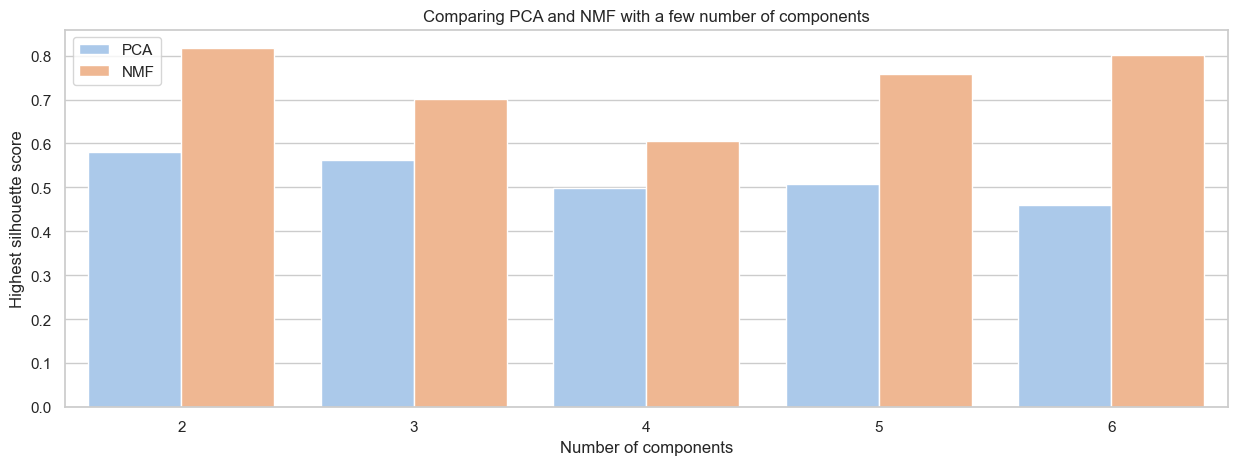

In [132]:
plt.figure(figsize=(15,5))
sns.barplot(x = 'Number of components', y = 'Highest silhouette score', 
            hue = 'Reduction dimension type', data = df, palette='pastel')
plt.title("Comparing PCA and NMF with a few number of components")
plt.legend(loc="upper left");

We observe that, whatever the number of components, NMF has better results than PCA.

Be careful, this information should be taken with caution for several reasons:
- NMF dimension reduction was performed on raw data and not standardized or normalized. Indeed, the normalization displayed negative values in the matrix
- Although it is efficient, the NMF method is mainly used in facial recognition or topic modeling

ACP remains a reliable and widespread method for size reduction

**To conclude, the kmeans algorithm is a powerful clustering algorithm. It is also one of the most widely used. However, the inertia that measured its performance has some limitations. To overcome them and optimize the performance of kmeans, it is highly recommended to apply a dimension reduction method such as PCA before running the algorithm.**